# Quantum phase estimation
**Using Q-CTRL performance management to enhance the performance of quantum phase estimation on IBM Quantum services**

This tutorial demonstrates the algorithmic performance improvements of Q-CTRL performance management when applied to the quantum phase estimation algorithm, which is a commonly used subroutine that serves as a building block for various algorithms. Q-CTRL performance management automatically reduces errors, enabling execution of deeper and wider circuits. This means that you can use more qubits in quantum phase estimation, broadening your application space.

This application note covers the following:
* An introduction to quantum phase estimation and how it is incorporated into quantum simulation algorithms.
* Definition of a simple instance of quantum phase estimation. 
* Execution of the circuits on an ideal simulator and on IBM Quantum services with and without Q-CTRL.
* Analysis of the results and conclusions.

The example in this notebook is inspired by the [Qiskit documentation](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation).

## 1. Introduction to quantum phase estimation

### 1.1 Definition of the problem of quantum phase estimation

The goal of quantum phase estimation is to provide an estimate on the eigenvalues of a unitary operation $U$.
For an $n$ qubit unitary $U$, it's possible to derive:
1. An $n$ qubit quantum circuit that applies controlled $U$ operations.
2. An eigenstate $\vert \varphi \rangle$ of $U$ according to the eigenvalue equation $U \vert \varphi \rangle = e^{2 \pi i \varphi} \vert \varphi \rangle$, and
Given $m$ additional qubits, known as the "counting qubits", quantum phase estimation computes the phase $\varphi$ up to an error $\epsilon$ by encoding it into the counting qubit register.
Through this procedure, the error $\epsilon$ becomes exponentially small in the number of counting qubits, $\epsilon = O(1 / 2^m)$.
The quantum phase estimation circuit looks as follows:

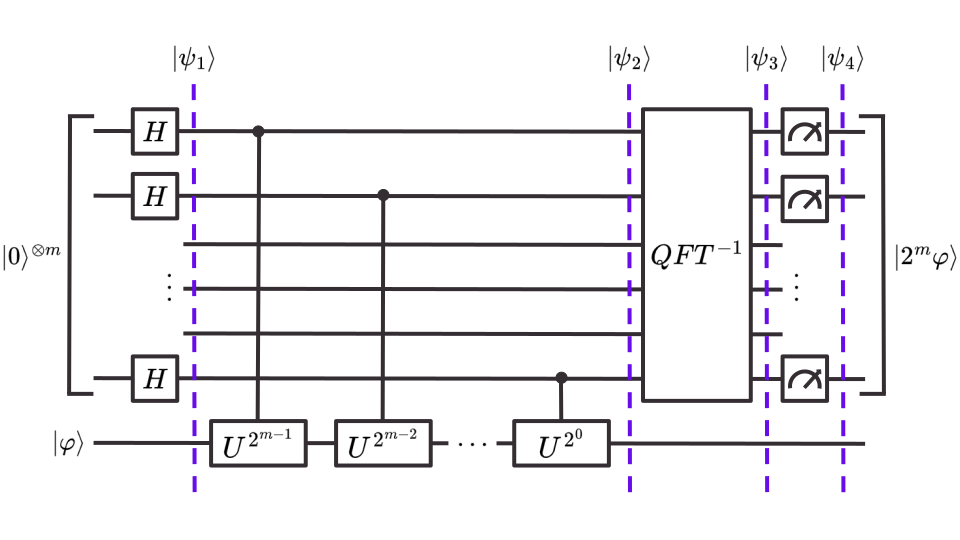

From this circuit, it can be inferred the quantum circuit implementing $U$ $O(1 / \epsilon)$ must be called many times.
Later, you'll learn how to encode the phase $\varphi$ in the final quantum state and how to retrieve it from measuring the counting qubits.
For mathematical details on how this quantum circuit works, refer to the [Qiskit documentation](https://learn.qiskit.org/course/ch-algorithms/quantum-phase-estimation).

Even if there is only access to an input state $\vert \psi \rangle$, which is not an eigenstate of $U$, it is still possible perform quantum phase estimation.
In this case, the algorithm projects the input qubits to a specific eigenstate $\vert \varphi_j \rangle$ of $U$ with a probability $p_j = \vert \langle \psi \vert \varphi_j \rangle \vert^2$ and computes the corresponding phase $\varphi_j$.
Therefore, in general quantum phase estimation samples the eigenvalues of $U$ from a probability distribution defined by the input state.
By repeating the algorithm many times, you can obtain an estimate of all eigenvalues of $U$ with nonzero $p_j$.
Notice that with a large number of repetitions it becomes exponentially likely to sample a given eigenvalue at least once.
For example, even for a small overlap of say $p_j = 0.01$, a shot count of $1,000$ suffices to recover $\varphi_j$ with a high probability.

### 1.2 Relevance of quantum phase estimation

Quantum phase estimation is a subroutine in many important quantum algorithms including the simulation of chemical materials such as drugs or fertilizers and Shor's algorithm for RSA decryption.
It can be used in quantum chemistry algorithms, which could enable the discovery of novel medicine or improve the reaction outcomes in industrial production of chemicals.

Many physical properties of chemical materials are derived from the eigenvalues of their corresponding Hamiltonian $H$.
Specifically, the ground state energy (smallest eigenvalue) is an important figure of merit.
By encoding $H$ into a unitary $U$, quantum phase estimation can be used to find the eigenvalues.
There are various ways to perform this encoding, for example:
1. [Hamiltonian simulation](https://learn.microsoft.com/en-us/azure/quantum/user-guide/libraries/chemistry/concepts/algorithms) through Trotterisation,
2. [Linear combination of unitaries](https://arxiv.org/abs/1202.5822), and
3. [Qubitization](https://pennylane.ai/blog/2021/11/quantum-computing-for-quantum-chemistry-a-brief-perspective/) through a block encoding.

Decoding the results from quantum phase estimation for the corresponding unitary $U$ allows us to conclude what are the eigenvalues of $H$.

### 1.3 Encoding of the eigenvalues

By using phase kickback, quantum phase estimation provides a binary encoding of the phase $\varphi$ in the final state of the counting qubit register.
For example, consider the case of $\varphi = 0.25$ on a quantum computer with $m = 3$ counting qubits.
This quantum computer has $2^m = 2^3 = 8$ different states, which are labeled by all possible 3-digit bitstrings $\vert 000 \rangle, \vert 001 \rangle, \dots,\vert 111 \rangle$.
Each of these bitstrings encodes a number $q$ between 0 and 7—in the exact same way as on a classical computer.
That is, $\vert 000 \rangle \equiv 0, \vert 001 \rangle \equiv 1, \dots$.
Dividing each of these numbers by $8$, that is computing $q / 2^m$, results in numbers between $0$ and $1$, which encode the phase (up to a multiple of $2 \pi$).
In our case, $\varphi = 0.25 = 2 / 8$, and hence the expected measured state is $\vert 010 \rangle \equiv 2$ after quantum phase estimation.
The above discussion is summarized in the following table:
<a name="quantum_phase_estimation_table"></a>

| Quantum state (bitstring) | Encoded number $q$    | Represented phase $\varphi = q / 2^m$ |
|---    |---    |---    |
| $\vert 000 \rangle$   | $0$   | $0$   |
| $\vert 001 \rangle$ |  $1$    | $0.125$ |
| $\mathbf{\color{#680CE9}{\vert 010 \rangle}}$   | $\mathbf{\color{#680CE9}{2}}$   | $\mathbf{\color{#680CE9}{0.25}}$    |
| $\vert 011 \rangle$   | $3$   | $0.375$   |
| $\vert 100 \rangle$   | $4$   | $0.5$ |
| $\vert 101 \rangle$   | $5$   | $0.625$   |
| $\vert 110 \rangle$   | $6$   | $0.75$    |
| $\vert 111 \rangle$   | $7$   | $0.875$   |

But what happens if the actual phase was not an inverse multiple of $8$?
For instance, imagine a scenario where $\varphi = 0.3$.
In this case, there is no $q / 2^m$, which represents $\varphi$ exactly.
However, quantum phase estimation can still be used to obtain an estimate of the phase.
The phase $\varphi = 0.3$ lies between $0.25$ and $0.375$ but is closer to $0.25$.
For this reason, after performing the quantum phase estimation algorithm, you will obtain a quantum state which has its maximum probability amplitude in $\vert 010 \rangle$ encoding a phase of $0.25$.
Nevertheless, as opposed to the previous example of $\varphi = 0.25$, you will also receive a nonzero probability amplitude in other quantum states.
In general, quantum phase estimation will give us an estimate for the actual phase by providing a lower and upper bound:
One bound is always given by the highest amplitude bitstring.
The other bound is given by the higher amplitude state next to it.
In the case of $\varphi = 0.3$, the two bitstrings next to the highest amplitude one are given by the state $\vert 001 \rangle \equiv 0.125$ (left) and $\vert 011 \rangle \equiv 0.375$ (right).
Thus, the state $\vert 011 \rangle$ has a higher amplitude than the state $\vert 001 \rangle$ as the desired phase is between $0.25$ and $0.375$.

### 1.4. Improving quantum phase estimation with performance management
The algorithm uses qubits for two purposes: one set of qubits (known as counting qubits) is used as a control and the other is used to perform operations.
To increase the accuracy of the phase estimate, the number of counting qubits $m$ must be increased.
However, increasing qubits also increases the likelihood of the device succumbing to errors.
With Q-CTRL performance management, errors are suppressed automatically during execution so that you can use more qubits to improve the results of phase estimation.

## 2. Imports and initialization
The following section sets up the necessary imports and helper functions, which will be used in creating and evaluating the circuits.

In [3]:
# Import packages.
import math
import numpy as np
import matplotlib.pyplot as plt
import json
from qiskit import QuantumCircuit, Aer, transpile
import qctrlvisualizer as qv

plt.style.use(qv.get_qctrl_style())


# Define the functions to create the quantum phase estimation circuits.
def power_of_two_q(number):
    """
    Ask whether a number is a power of 2.
    """
    return math.ceil(np.log2(number)) == math.floor(np.log2(number))


def inverse_quantum_fourier_transform(quantum_circuit, number_of_qubits):
    """
    Apply an inverse Quantum Fourier Transform the first `number_of_qubits` qubits in the
    `quantum_circuit`.
    """
    for qubit in range(number_of_qubits // 2):
        quantum_circuit.swap(qubit, number_of_qubits - qubit - 1)
    for j in range(number_of_qubits):
        for m in range(j):
            quantum_circuit.cp(-math.pi / float(2 ** (j - m)), m, j)
        quantum_circuit.h(j)


def create_circuit(number_of_counting_qubits, phase):
    """
    Create a quantum circuit for quantum phase estimation. The unitary, whose phase is evaluated
    is a single qubit phase gate. Its phase can be specified by the input parameter `phase`.
    """
    # Initialize the quantum circuit.
    quantum_circuit = QuantumCircuit(
        number_of_counting_qubits + 1, number_of_counting_qubits
    )
    quantum_circuit.x(number_of_counting_qubits)
    for qubit in range(number_of_counting_qubits):
        quantum_circuit.h(qubit)

    # Add the controlled phase gates to the circuit.
    repetitions = 1
    for counting_qubit in range(number_of_counting_qubits):
        for _ in range(repetitions):
            quantum_circuit.cp(phase, counting_qubit, number_of_counting_qubits)
        repetitions *= 2

    quantum_circuit.barrier()

    # Apply the inverse quantum Fourier transform.
    inverse_quantum_fourier_transform(quantum_circuit, number_of_counting_qubits)

    # Measure the ancilla register.
    quantum_circuit.barrier()
    for qubit in range(number_of_counting_qubits):
        quantum_circuit.measure(qubit, qubit)

    return quantum_circuit


def bitstring_count_to_probabilities(data, shot_count, number_of_counting_qubits):
    """
    Manipulate the measured and simulated results.
    This function turns an unsorted dictionary of bitstring counts into a sorted dictionary
    of probabilities. It also turns bitstrings from base 0 to base 2 and adds bitstrings,
    with zero count that do not appear in the original dictionary.
    """
    # Check if the base of the bitstrings is 0 and turn it into base 2 in this case.
    if any("x" in key for key in data.keys()):
        base = 0
    else:
        base = 2

    # Turn the bitstring counts into probabilities.
    probabilities = {
        format(int(bitstring, base), f"0{number_of_counting_qubits}b"): bitstring_count
        / shot_count
        for bitstring, bitstring_count in data.items()
    }

    # Add bitstrings with zero count that do not appear in the dictionary.
    padded_probabilities = pad_missing_values(
        probabilities, number_of_counting_qubits=number_of_counting_qubits
    )

    # Sort the dictionary.
    sorted_probabilities = dict(sorted(padded_probabilities.items()))

    return sorted_probabilities


def reformat_results(
    results, number_of_counting_qubits, experiments_per_phase, phases, shot_count
):
    """
    Reformats list of quasi-probability distributions to an array of binary probabilities.
    """
    binary_results = []
    for experiment in results:
        # Get the binary probabilities distribution.
        binary_result = bitstring_count_to_probabilities(
            experiment.c.get_counts(), shot_count, number_of_counting_qubits
        )

        binary_results.append(binary_result)

    # Create an array with split up experiment data.
    binary_results_arr = np.array(binary_results)
    split_results = np.split(
        binary_results_arr[0 : experiments_per_phase * len(phases)],
        experiments_per_phase,
    )
    return split_results


def pad_missing_values(data, number_of_counting_qubits):
    """
    Add bitstrings with zero count that do not appear in the dictionary.
    """
    all_bitstrings = [
        format(i, f"0{number_of_counting_qubits}b")
        for i in range(2**number_of_counting_qubits)
    ]
    data_with_missing_values = {
        bitstring: data.get(bitstring, 0.0) for bitstring in all_bitstrings
    }
    return data_with_missing_values

## 3. Creating the circuits
Here, 10 different phases are defined and the circuit will be run for each phase twice.
In this way, you obtain 20 data points per number of counting qubits.
We exclude phases that are an inverse power of two to avoid exact results.
This is a more realistic scenario closer to a real quantum chemistry application.

In [4]:
# Set parameters.
shot_count = 4096
phases = [1 / number for number in np.arange(1, 15) if power_of_two_q(number) is False]
experiments_per_phase = 2

# Set up the 5-qubit circuit.
circuits_quantum_phase_estimation_5 = [
    create_circuit(5, phase) for phase in phases
] * experiments_per_phase
print(
    "Quantum phase estimation circuit with m=5 counting qubits and a phase of 𝜑=0.2/2π:"
)
display(circuits_quantum_phase_estimation_5[0].draw(fold=-1))

# Set up the 6-qubit circuit.
circuits_quantum_phase_estimation_6 = [
    create_circuit(6, phase) for phase in phases
] * experiments_per_phase
print(
    "Quantum phase estimation circuit with m=6 counting qubits and a phase of 𝜑=0.2/2π:"
)
display(circuits_quantum_phase_estimation_6[0].draw(fold=-1))

Quantum phase estimation circuit with m=5 counting qubits and a phase of 𝜑=0.2/2π:


┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                    ░    ┌───┐                                                                                                                          ░ ┌─┐            
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──X─┤ H ├─■──────────────■───────────────────■────────────────────────■────────────────────────────────────────────────────────────░─┤M├────────────
     ├───┤ │                                                                                                                                                                                                                                                                                                                                                                                                                  ░  │ └───┘ │P(-π/2) ┌───┐ │                   │                        │                                                            ░ └╥┘┌─┐         
q_1: ┤ H ├─┼────────────■────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──┼───X───■────────┤ H ├─┼─────────■─────────┼──────────────■─────────┼────────────────────■───────────────────────────────────────░──╫─┤M├─────────
     ├───┤ │            │            │                                                                                                                                                                                                                                                                                                                                                                                        ░  │   │            └───┘ │P(-π/4)  │P(-π/2)  │        ┌───┐ │         │                    │                                       ░  ║ └╥┘┌─┐      
q_2: ┤ H ├─┼────────────┼────────────┼────────────■────────────■────────────■────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──┼───┼──────────────────■─────────■─────────┼────────┤ H ├─┼─────────┼──────────■─────────┼──────────────■────────────────────────░──╫──╫─┤M├──────
     ├───┤ │            │            │            │            │            │            │                                                                                                                                                                                                                                                                                                                                    ░  │   │                                      │P(-π/8) └───┘ │P(-π/4)  │          │P(-π/2)  │        ┌───┐ │                        ░  ║  ║ └╥┘┌─┐   
q_3: ┤ H ├─┼────────────┼────────────┼────────────┼──────

Quantum phase estimation circuit with m=6 counting qubits and a phase of 𝜑=0.2/2π:


┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    ░    ┌───┐                                                                                                                                                                                   ░ ┌─┐               
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──X─┤ H ├─■──────────────■───────────────────■────────────────────────■──────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────░─┤M├───────────────
     ├───┤ │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ░  │ └───┘ │P(-π/2) ┌───┐ │                   │                        │                              │                                                                                      ░ └╥┘┌─┐            
q_1: ┤ H ├─┼────────────■────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──┼───X───■────────┤ H ├─┼─────────■─────────┼────────

## 4. Running the algorithm

In this section, the circuits are run on an ideal simulator and on real hardware both with and without Q-CTRL performance management for comparison.

### 4.1 Running on an ideal simulator

In order to assess the quality of the measured results, first run the quantum circuits on an ideal, noiseless simulator. This will serve as a benchmark for comparison.

In [5]:
# Get the simulator backend.
aer_simulator = Aer.get_backend("aer_simulator")

# Transpile circuits.
transpiled_circuits_5 = transpile(circuits_quantum_phase_estimation_5, aer_simulator)
transpiled_circuits_6 = transpile(circuits_quantum_phase_estimation_6, aer_simulator)

# Run the circuits on the simulator.
simulated_result_5 = (
    aer_simulator.run(transpiled_circuits_5, shots=shot_count).result().get_counts()
)
simulated_result_6 = (
    aer_simulator.run(transpiled_circuits_6, shots=shot_count).result().get_counts()
)

# Reformat the results as probabilities instead of counts.
simulated_result_5 = [
    bitstring_count_to_probabilities(result, shot_count, 5)
    for result in simulated_result_5
]
simulated_result_6 = [
    bitstring_count_to_probabilities(result, shot_count, 6)
    for result in simulated_result_6
]

### 4.2 Setting up your IBM Cloud account
The Q-CTRL performance management strategy can be used with Qiskit Runtime on IBM Cloud. To configure an instance with Q-CTRL enabled, read through the [set up documentation](https://docs.q-ctrl.com/q-ctrl-embedded/ibm/set-up/configure-q-ctrl-on-ibm-quantum-services).

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Note: This assumes you have already followed the setup instructions.
# https://docs.q-ctrl.com/q-ctrl-embedded/ibm/set-up/configure-q-ctrl-on-ibm-quantum-services
service = QiskitRuntimeService(name="q-ctrl")

In [7]:
# Choose a backend that supports Q-CTRL performance management.
backend_name = "ibm_brisbane"
backend = service.get_backend(backend_name)

### 4.3 Running the algorithm with Q-CTRL performance management
First, run the circuits on IBM Quantum services using Q-CTRL performance management. 

Note that due to device queues, there may be a significant delay in receiving results. To retrieve previously executed jobs, skip to the following cells.

In [ ]:
from qiskit_ibm_runtime import Session, Sampler

backend = service.get_backend(backend_name)
with Session(service=service, backend=backend):
    sampler = Sampler()
    # Run the 5 and 6 counting qubit circuits with Q-CTRL.
    q_ctrl_results = sampler.run(
        [circuits_quantum_phase_estimation_5, circuits_quantum_phase_estimation_6],
        shots=shot_count,
    ).result()
    q_ctrl_results_5 = q_ctrl_results[0]
    q_ctrl_results_6 = q_ctrl_results[1]

If you ran the jobs previously, you can retrieve job results as follows.

In [ ]:
# Retrieve previously submitted job results.
q_ctrl_results = service.job("<Job ID>").result()
q_ctrl_results_5 = q_ctrl_results[0]
q_ctrl_results_6 = q_ctrl_results[1]

### 4.4 Running the algorithm on quantum hardware with default settings

Next, you will run the quantum circuits for quantum phase estimation on IBM Quantum services without using Q-CTRL's performance management strategy.
In order to do so, you'll need to [set up or specify an instance of Qiskit Runtime that does not have Q-CTRL enabled](https://cloud.ibm.com/catalog/services/qiskit-runtime). 

Once again, execution may be delayed due to device queues. To retrieve previously executed jobs, skip to the following cells.

In [89]:
# Use the CRN of the instance without Q-CTRL performance management.
# Do not set a channel_strategy.
service = QiskitRuntimeService(
    channel="ibm_cloud", token="<IBM Cloud API key>", instance="<IBM Cloud CRN>"
)

In [ ]:
# Use the same backend but initialize it for the service instance without Q-CTRL.
backend_default = service.get_backend(backend_name)

This time, you'll be running the circuits without the Q-CTRL performance management strategy. The Sampler will use default error supression and mitigation.

In [ ]:
with Session(service=service, backend=backend_default):
    sampler = Sampler()
    # Run the 5 and 6 counting qubit circuits with default Sampler settings.
    default_results = sampler.run(
        [circuits_quantum_phase_estimation_5, circuits_quantum_phase_estimation_6],
        shots=shot_count,
    ).result()
    default_results_5 = default_results[0]
    default_results_6 = default_results[1]

In [27]:
# Retrieve previously submitted job results.
default_results = service.job("<Job ID>").result()
default_results_5 = default_results[0]
default_results_6 = default_results[1]

## 5. Reformat the results to analyze and display

In [12]:
# Reformat the distributions to binary keys and split up the experiments.
q_ctrl_split_exp_5 = reformat_results(
    q_ctrl_results_5,
    number_of_counting_qubits=5,
    experiments_per_phase=experiments_per_phase,
    phases=phases,
    shot_count=shot_count,
)
q_ctrl_split_exp_6 = reformat_results(
    q_ctrl_results_6,
    number_of_counting_qubits=6,
    experiments_per_phase=experiments_per_phase,
    phases=phases,
    shot_count=shot_count,
)

default_split_exp_5 = reformat_results(
    default_results_5,
    number_of_counting_qubits=5,
    experiments_per_phase=experiments_per_phase,
    phases=phases,
    shot_count=shot_count,
)
default_split_exp_6 = reformat_results(
    default_results_6,
    number_of_counting_qubits=6,
    experiments_per_phase=experiments_per_phase,
    phases=phases,
    shot_count=shot_count,
)

In [13]:
# Combine datasets.
data_5 = {
    "simulation": simulated_result_5,
    "default": default_split_exp_5,
    "q_ctrl": q_ctrl_split_exp_5,
}

data_6 = {
    "simulation": simulated_result_6,
    "default": default_split_exp_6,
    "q_ctrl": q_ctrl_split_exp_6,
}

## 6. Analyzing the data

Let's assess the data obtained.
For this, first plot the ideal and measured distributions.

In [14]:
# Define the functions to plot the distributions.
def highest_count_bitstring(data):
    """
    Return the bitstring with the highest count for the measurement results of a single shot.
    """
    return max(data, key=data.get)


def counting_qubits(data):
    """
    Check whether all passed dictionaries with single shot measurements belong to the same
    number of counting qubits and return this number.
    """
    first_keys = iter(list(result.keys())[0] for result in data.values())
    number_of_counting_qubits = len(next(first_keys))

    if not all(len(key) == number_of_counting_qubits for key in first_keys):
        raise ValueError(
            "The input data must contain dictionaries corresponding to the same number of counting qubits."
        )

    return number_of_counting_qubits


def plot_distributions(data, phase_index, number_of_counting_qubits):
    """
    Plot the distributions of all single shot measurements for all three experiments
    "simulation", "default" and "ibm" in one plot.
    """
    # number_of_counting_qubits = counting_qubits(data)
    phase = f"1/{int(1/phases[phase_index])}"

    simulation = data["simulation"]
    default = data["default"]
    q_ctrl = data["q_ctrl"]

    correct_result = highest_count_bitstring(simulation)

    max_probability = max(
        max(simulation.values()), max(default.values()), max(q_ctrl.values())
    )

    figure, axes = plt.subplots(3, 1, layout="constrained")

    # Ideal simulation
    bars_simulation = axes[0].bar(
        list(simulation.keys()),
        list(simulation.values()),
        color=qv.QCTRL_STYLE_COLORS[5],
    )
    axes[0].set_title("Ideal simulation")
    bars_simulation[list(simulation.keys()).index(correct_result)].set_color(
        qv.QCTRL_STYLE_COLORS[8]
    )

    # Default
    bars_default = axes[1].bar(
        list(default.keys()), list(default.values()), color=qv.QCTRL_STYLE_COLORS[1]
    )
    axes[1].set_title("Default")
    bars_default[list(default.keys()).index(correct_result)].set_color(
        qv.QCTRL_STYLE_COLORS[8]
    )

    # Q-CTRL
    bars_q_ctrl = axes[2].bar(
        list(q_ctrl.keys()), list(q_ctrl.values()), color=qv.QCTRL_STYLE_COLORS[0]
    )
    axes[2].set_title("Q-CTRL")
    bars_q_ctrl[list(q_ctrl.keys()).index(correct_result)].set_color(
        qv.QCTRL_STYLE_COLORS[8]
    )

    for axis in axes.flat:
        axis.set(xlabel="Bitstrings", ylabel="Probabilities")
        axis.set_ylim([0, 1.05 * max_probability])
        axis.tick_params(axis="x", labelrotation=90)

    # Hide labels and tick labels for inner plots.
    for axis in axes.flat:
        axis.label_outer()

    figure.suptitle(
        rf"{number_of_counting_qubits} counting qubits, $2 \pi \varphi$={phase}"
    )
    figure.set_size_inches(20, 10)

    plt.show()

### 6.1 Plot the distributions to compare the ideal, default, and Q-CTRL results

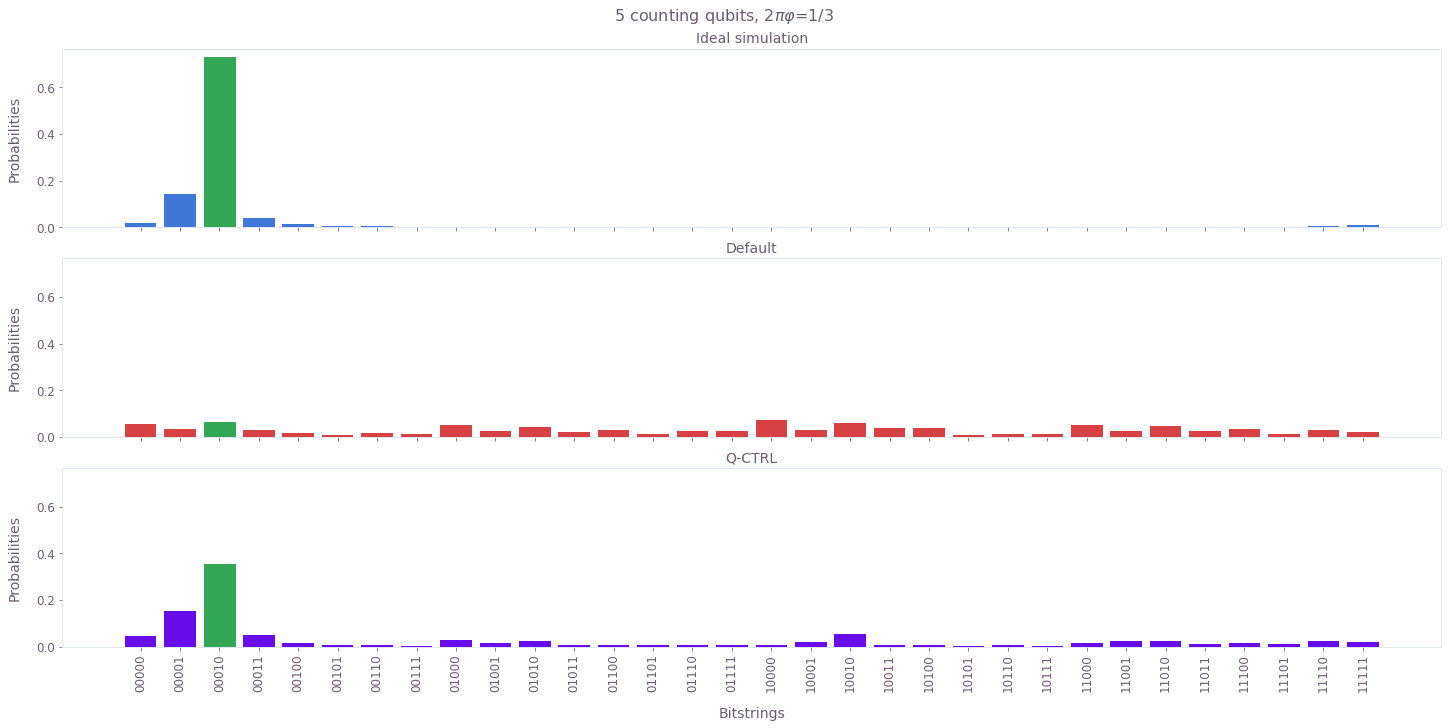

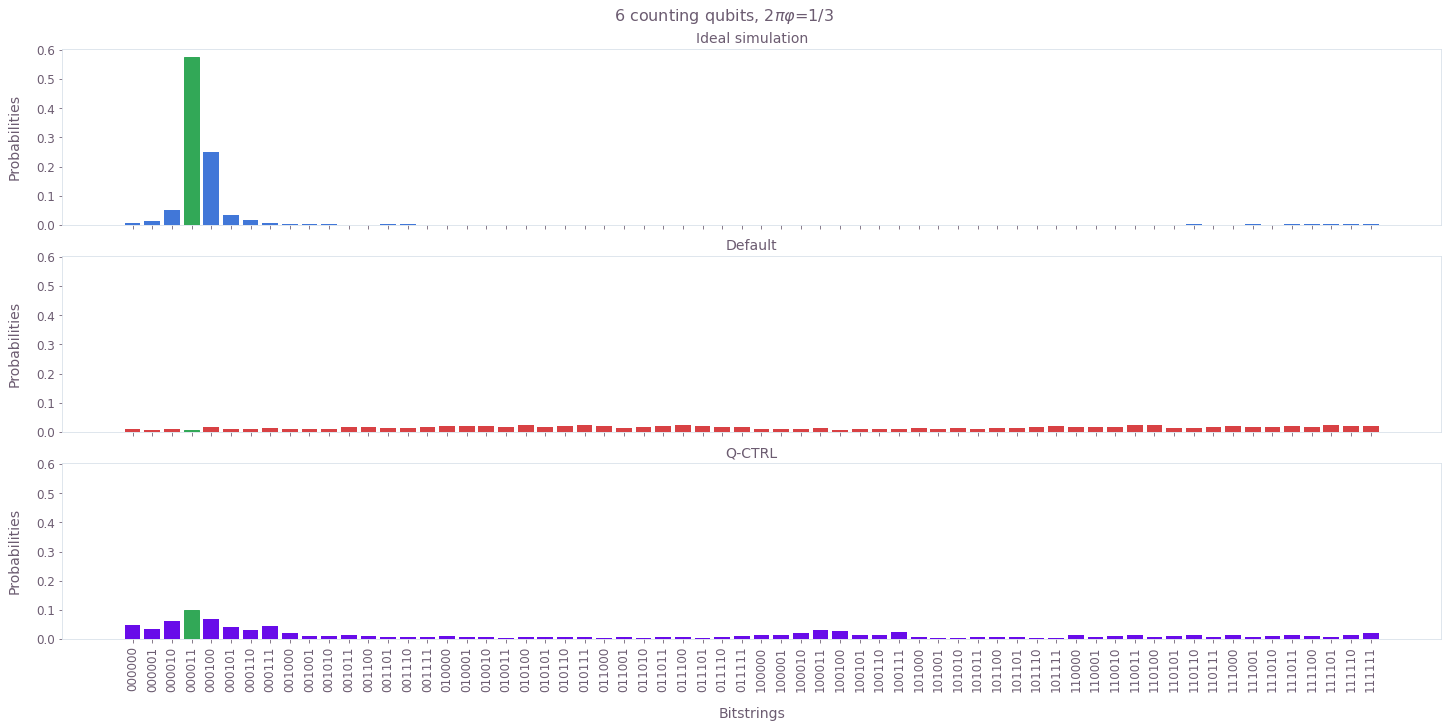

In [15]:
# Specify, which of the data sets to plot by specifying the index of the
# experiment (that is, run 0 or run 1) and the index of the phase in the list
# `phases`. Remember that the experiment was performed twice for each phase,
# so the `experiment_index` specifies, which run is plotted.
experiment_index = 0
phase_index = 0

# Plot the distributions for 5 counting qubits.
distributions_5 = {
    "simulation": data_5["simulation"][phase_index],
    "default": data_5["default"][experiment_index][phase_index],
    "q_ctrl": data_5["q_ctrl"][experiment_index][phase_index],
}
plot_distributions(distributions_5, phase_index, 5)

# Plot the distributions for 6 counting qubits.
distributions_6 = {
    "simulation": data_6["simulation"][phase_index],
    "default": data_6["default"][experiment_index][phase_index],
    "q_ctrl": data_6["q_ctrl"][experiment_index][phase_index],
}

plot_distributions(distributions_6, phase_index, 6)

### 6.2 Analyze results and compare success rates

As you can see, the results obtained without Q-CTRL performance management are very different to the ideal, correct distribution.
Due to high noise, the qubits get corrupted while the quantum phase estimation circuit is running.
This leads to measurement distributions, which look pretty much random and meaningless.
In contrast, Q-CTRL produces the correct results and the measurement distributions look much more similar to the ideal ones.

Even for $m = 6$ counting qubits, Q-CTRL performance management recovers the same phase as the ideal simulation.
Due to a decent number of counting qubits, a good estimate for the phase is obtained in this case.
The actual phase here is $\varphi = \frac{1}{6 \pi} \approx 0.0531$.
Q-CTRL results predict a phase between $3 / 2^6 \approx 0.0469$ and $4 / 2^6 = 0.0625$, but closer to $0.0469$, which is a reasonable approximation.

Success rate—how often the correct highest count bitstring was found—is a metric that can further evaluate the quality of your results.
Even if the success probability of a single experiment is low, if you are consistently achieving the correct result, repeating an experiment provides extra validation that your answer is correct.

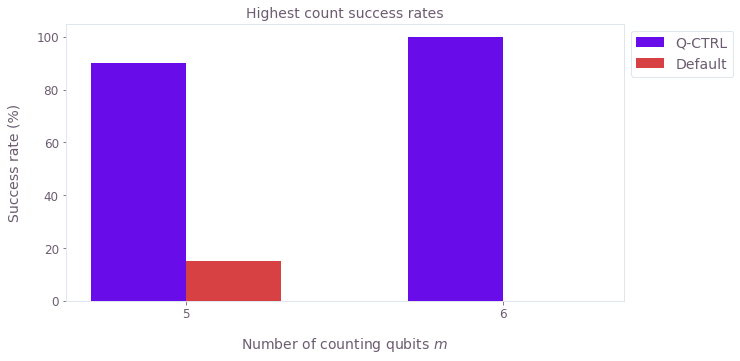

In [16]:
def success_rate(data):
    """
    Compare the highest count bitstring of the ideal simulation with the ones obtained
    from the measurements. Return the percentage of correct predictions.
    """
    simulation = data["simulation"]
    q_ctrl = data["q_ctrl"]
    default = data["default"]

    simulation_results = [highest_count_bitstring(ideal) for ideal in simulation]

    q_ctrl_results = [
        highest_count_bitstring(result) for results in q_ctrl for result in results
    ]

    default_results = [
        highest_count_bitstring(result) for results in default for result in results
    ]

    correct_results_q_ctrl = 0
    correct_results_default = 0

    for phase_index, correct_result in enumerate(simulation_results):
        if q_ctrl_results[phase_index] == correct_result:
            correct_results_q_ctrl += 1
        if default_results[phase_index] == correct_result:
            correct_results_default += 1

    return (
        100 * correct_results_q_ctrl / len(q_ctrl_results),
        100 * correct_results_default / len(default_results),
    )


def plot_success_rates(data):
    """
    Plot the success rates of both experiments for the number of counting qubits.
    """
    q_ctrl, default = zip(*data.values())

    bar_width = 0.3

    x_ticks = np.array(list(data.keys()))
    plt.xticks(ticks=x_ticks)

    # Q-CTRL
    plt.bar(
        x_ticks - bar_width / 2,
        q_ctrl,
        color=qv.QCTRL_STYLE_COLORS[0],
        width=bar_width,
        label="Q-CTRL",
    )

    # Sampler default
    plt.bar(
        x_ticks + bar_width / 2,
        default,
        color=qv.QCTRL_STYLE_COLORS[1],
        width=bar_width,
        label="Default",
    )

    plt.title("Highest count success rates")
    plt.xlabel(r"Number of counting qubits $m$")
    plt.ylabel("Success rate (%)")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

    plt.show()


success_rates = {5: success_rate(data_5), 6: success_rate(data_6)}
plot_success_rates(data=success_rates)

As you can see, Q-CTRL performance management consistently predicts the correct answer even as the number of counting qubits increases. Without Q-CTRL performance management, the algorithm was unable to scale past even 5 counting qubits. You can even try higher numbers of counting qubits to see that Q-CTRL continues to scale.

## 7. Conclusion

From the success rates, you can see that with the Q-CTRL performance management, it's possible to achieve a high success rate even with higher numbers of counting qubits.
In contrast, success rates start to decline after 5 counting qubits when executing without Q-CTRL.

Q-CTRL allows you to get correct answers from quantum phase estimation that are otherwise unattainable, and these results can be attained without additional overhead.
By allowing you to scale to higher numbers of counting qubits without any performance degradation, Q-CTRL performance management provides better accuracy for the estimated phase.
This tutorial demonstrates one algorithm that can be executed with Q-CTRL performance management on IBM Quantum services, but any other algorithm can also benefit.